In [1]:
# import necessary libraries
import gdown
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from collections import Counter
import matplotlib.pyplot as plt
#tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant

# <font color='orange'>8. Approach 2: Generating Responses by cluster label

In this approach we will group similar responses in clusters and will map the input text to these cluster labels. We will then randomly select some responses from the clusters as machine generated responses.

Steps of the process followed in this approach:

1. Generate Sentence Embeddings
2. Create clusters based on these embeddings
3. Map input text data to cluster labels
4. Select reponses from predicted cluster 

## <font color='brown'>Get data

In [2]:
# Download data
!gdown 1IrOiTv7wl1Yf3C2x66PRSny8-TCeT8zF

Downloading...
From: https://drive.google.com/uc?id=1IrOiTv7wl1Yf3C2x66PRSny8-TCeT8zF
To: /content/clustering_df.csv
100% 3.51M/3.51M [00:00<00:00, 258MB/s]


In [3]:
# read data
clustering_data = pd.read_csv("clustering_df.csv")
clustering_data.head()

,clean_input,clean_output
0,this was a best friend i miss her,where has she gone ?
1,we no longer talk,oh was this something that happened because of...
2,was this a friend you were in love with or jus...,this was a best friend
3,where has she gone ?,we no longer talk
4,it feels like hitting to blank wall when i se...,oh ya ? i do not really see how


In [4]:
# Train test split
train, validation = train_test_split(clustering_data, test_size=0.1, random_state=42)
print(f"Train shape: {train.shape}")
print(f"Validation shape: {validation.shape}")

Train shape: (34149, 2)
Validation shape: (3795, 2)


## <font color='brown'>8.1 Sentence Embeddings using Sentence BERT

###8.1.1 Intsall and import Sentence BERT

In [5]:
# Intsallation
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=2ab03e9d61e71a1698833f5860711b8acad98d4ca6e7e1edf04c1fb701dc4a35
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [6]:
# Import
from sentence_transformers import SentenceTransformer

# why all-MiniLM-L6-v2? Refer: https://www.sbert.net/docs/pretrained_models.html
sent_bert = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Size of Embeddings given by Sentence-BERT: {sent_bert.max_seq_length}")

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Size of Embeddings given by Sentence-BERT: 256


Note:- But, actually sent_bert model provided 384 dimensional embeddings.

###8.1.2 Generate and save embeddings

In [8]:
train_input_texts = train['clean_input'].values
val_input_texts = validation['clean_input'].values

In [9]:
#sentences we want to encode
train_response_texts = train['clean_output'].values
val_response_texts = validation['clean_output'].values
# response_texts = clustering_data['clean_output']
# Initialize sentence-embedding dict
sent_emb_dict = {}

#Sentences are encoded by calling model.encode()
for sent in tqdm(train_response_texts):
    emb = sent_bert.encode(str(sent))
    sent_emb_dict[sent] = emb

100%|██████████| 34149/34149 [03:56<00:00, 144.50it/s]


In [10]:
print(f"Length of sent_emb_dict: {len(sent_emb_dict)}")

Length of sent_emb_dict: 27915


In [11]:
# Initialize sentence-embedding dict
sent_emb_dict_val = {}
#Sentences are encoded by calling model.encode()
for sent in tqdm(val_response_texts):
    emb = sent_bert.encode(str(sent))
    sent_emb_dict_val[sent] = emb

100%|██████████| 3795/3795 [00:23<00:00, 159.00it/s]


In [12]:
# saving embeddings
with open('sentence_embeddings.pkl', "wb") as f:
    pickle.dump(sent_emb_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

with open('sentence_embeddings_val.pkl', "wb") as f:
    pickle.dump(sent_emb_dict_val, f, protocol=pickle.HIGHEST_PROTOCOL)
#Load sentences & embeddings from disc
# with open('embeddings.pkl', "rb") as fIn:
#     stored_data = pickle.load(fIn)
#     stored_sentences = stored_data['sentences']
#     stored_embeddings = stored_data['embeddings']

In [13]:
train_embeddings = []
for sent in tqdm(train['clean_output']):
    emb = sent_emb_dict.get(sent)
    train_embeddings.append(emb)
train_embeddings = np.array(train_embeddings).reshape(-1, 384)


val_embeddings = []
for sent in tqdm(validation['clean_output']):
    emb = sent_emb_dict_val.get(sent)
    val_embeddings.append(emb)
val_embeddings = np.array(val_embeddings).reshape(-1, 384)
print('\n')
print(f"Train embeddings.shape: {train_embeddings.shape}")
print(f"val embeddings.shape: {val_embeddings.shape}")

100%|██████████| 3795/3795 [00:00<00:00, 1127772.69it/s]



Train embeddings.shape: (34149, 384)
val embeddings.shape: (3795, 384)


## <font color='brown'>8.2 Clustering the embeddings using DBSCAN

In [ ]:
%%time
eps_list = []
eps_clusters = []
eps_noise = []
eps_vals = np.linspace(0, 0.6, num=35)

for eps in eps_vals:
    
    if eps > 0:   
            
        print(f"eps value = {eps}")
        # Compute DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=2, metric="cosine", n_jobs=-1)
        dbscan.fit(train_embeddings)
        labels = dbscan.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        eps_list.append(eps)
        eps_clusters.append(n_clusters_)
        eps_noise.append(n_noise_)

        print(f"Estimated number of clusters: {n_clusters_}")
        print(f"Estimated number of noise points: {n_noise_}")
        print("="*25)
        
        if n_clusters_ == 1:
            print("Stopping..")
            # least number of clusters
            break

eps value = 0.01764705882352941
Estimated number of clusters: 1428
Estimated number of noise points: 26198
eps value = 0.03529411764705882
Estimated number of clusters: 1496
Estimated number of noise points: 26000
eps value = 0.052941176470588235
Estimated number of clusters: 1597
Estimated number of noise points: 25634
eps value = 0.07058823529411765
Estimated number of clusters: 1657
Estimated number of noise points: 25142
eps value = 0.08823529411764705
Estimated number of clusters: 1715
Estimated number of noise points: 24548
eps value = 0.10588235294117647
Estimated number of clusters: 1753
Estimated number of noise points: 23869
eps value = 0.12352941176470589
Estimated number of clusters: 1789
Estimated number of noise points: 23216
eps value = 0.1411764705882353
Estimated number of clusters: 1865
Estimated number of noise points: 22409
eps value = 0.1588235294117647
Estimated number of clusters: 1921
Estimated number of noise points: 21617
eps value = 0.1764705882352941
Estimat

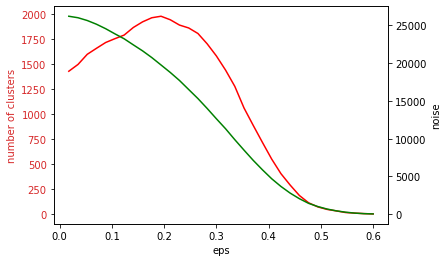

In [ ]:
# Plot clustering params
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('eps')
ax1.set_ylabel('number of clusters', color=color)
ax1.plot(eps_list, eps_clusters, color='red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

ax2.plot(eps_list, eps_noise, color='green')
ax2.set_ylabel('noise')
plt.show()

In [14]:
eps = 0.42
print(f"eps value = {eps}")
# Compute DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=2, metric="cosine", n_jobs=-1)
dbscan.fit(train_embeddings)
#core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")
print("="*25)

eps value = 0.42
Estimated number of clusters: 431
Estimated number of noise points: 3890


In [15]:
# Checking cluster samples
c = 0
for cluster_label in set(labels):
    class_member_mask = (labels == cluster_label)
    print("In cluster", cluster_label, "found", Counter(class_member_mask)[True], "points")
    print("Samples")
    print(np.array(train_response_texts)[class_member_mask])
    print("-------------------------------------")
    c += 1
    if c == 50:
        break

In cluster 0 found 29136 points
Samples
['im sorry to hear that' 'what pet does she have ?'
 'yes animals are our best friends' ... 'that is sad'
 'wow that should be interesting have fun'
 'everyone has their own family now']
-------------------------------------
In cluster 1 found 2 points
Samples
['i am but this girl is way out of my league'
 'i am i would like to win the league this year']
-------------------------------------
In cluster 2 found 6 points
Samples
['i will gotta keep my gpa up'
 'i am feeling confident because my gpa is 4'
 'i studied pretty hard so i am hoping for a great mark'
 'i hope so i am very eager to get my marks back'
 'i hope so too or else my gpa is screwed'
 'as long as you keep the gpa to what you need though']
-------------------------------------
In cluster 3 found 3 points
Samples
['yeah totally are you selfemployed too'
 'it is not easy to be successfully selfemployed but she did it'
 'that is cool are you selfemployed too']
------------------------

## <font color='brown'>8.3 Training LSTM model that predicts cluster label

###8.3.1 Preparing data for training

In [20]:
# predict dbscan_cluster_label for validation data

import numpy as np
import scipy as sp

def predict_cluster_label(dbscan_model, X_new, metric=sp.spatial.distance.cosine):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in tqdm(enumerate(X_new)):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break

    return y_new

val_cluster_labels = predict_cluster_label(dbscan, val_embeddings)

3795it [21:07,  2.99it/s]


In [37]:
unique_labels_count = len(set(dbscan.labels_))
train_cluster_labels = dbscan.labels_
print(f"No of unique labels in train data: {unique_labels_count}")

No of unique labels in train data: 432


Encoding cluster labels

In [48]:
train_cluster_labels = tf.one_hot(train_cluster_labels, depth=432)
val_cluster_labels = tf.one_hot(val_cluster_labels, depth=432)

Tokenizing

In [22]:
# Vectorizing texts using tokenizer
input_tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=@[\\]^_`{|}~\t\n')
input_tokenizer.fit_on_texts(train['clean_input'].values)

In [23]:
input_vocab_len = len(input_tokenizer.word_index) + 1

In [24]:
print(f"Input text vocab length: {input_vocab_len}")

Input text vocab length: 12982


Padding

In [25]:
ip_maxlen = max([len(i) for i in clustering_data['clean_input'].str.split()])
print(f"Input sentence max length: {ip_maxlen}")

Input sentence max length: 56


In [26]:
# Set max lengths parameter
IP_SENT_MAXLENGTH = 56

In [27]:
# tokenize and pad train sequences
clean_input_sequences = input_tokenizer.texts_to_sequences(train['clean_input'].values)
clean_input_sequences = pad_sequences(clean_input_sequences, maxlen=IP_SENT_MAXLENGTH, padding='post')

In [28]:
# tokenize and pad validation sequences
clean_input_seq_val = input_tokenizer.texts_to_sequences(validation['clean_input'].values)
clean_input_seq_val = pad_sequences(clean_input_seq_val, maxlen=IP_SENT_MAXLENGTH, padding='post')

In [29]:
# Shapes
print(f"clean_input_sequences shape: {clean_input_sequences.shape}")
print(f"clean_input_seq_val shape: {clean_input_seq_val.shape}")


clean_input_sequences shape: (34149, 56)
clean_input_seq_val shape: (3795, 56)


###8.3.2 Defining Model

In [64]:
# Define tensorflow model using functional API

## text-embedding-lstm-flatten layers
text_input = Input(shape=IP_SENT_MAXLENGTH, name='text_input')

text_embedding = Embedding(input_dim=input_vocab_len, output_dim=300,
                           input_length=IP_SENT_MAXLENGTH,
                           trainable=True,
                           name='text_embedding')(text_input)

text_lstm = LSTM(256, activation='tanh', name='text_lstm')(text_embedding)

text_flatten = Flatten(name='text_flatten')(text_lstm)

## Layers after Concatenation
first_dense = Dense(1024, activation='relu', name='first_dense')(text_flatten)
first_dropout = Dropout(0.4, name='first_dropout')(first_dense)
second_dense = Dense(512, activation='relu', name='second_dense')(first_dropout)
second_dropout = Dropout(0.25, name='second_dropout')(second_dense)
third_dense = Dense(256, activation='relu', name='third_dense')(second_dropout)
# fourth_dense = Dense(128, activation='relu', name='fourth_dense')(third_dense)
# fifth_dense = Dense(16, activation='relu', name='fifth_dense')(fourth_dense)
Output = Dense(432, activation='softmax', name='output')(third_dense)

# Initialize model
model_1 = Model(inputs=text_input,
                outputs=Output, name='Model_1')

# Model summary
model_1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, 56)]              0         
                                                                 
 text_embedding (Embedding)  (None, 56, 300)           3894600   
                                                                 
 text_lstm (LSTM)            (None, 256)               570368    
                                                                 
 text_flatten (Flatten)      (None, 256)               0         
                                                                 
 first_dense (Dense)         (None, 1024)              263168    
                                                                 
 first_dropout (Dropout)     (None, 1024)              0         
                                                                 
 second_dense (Dense)        (None, 512)               5248

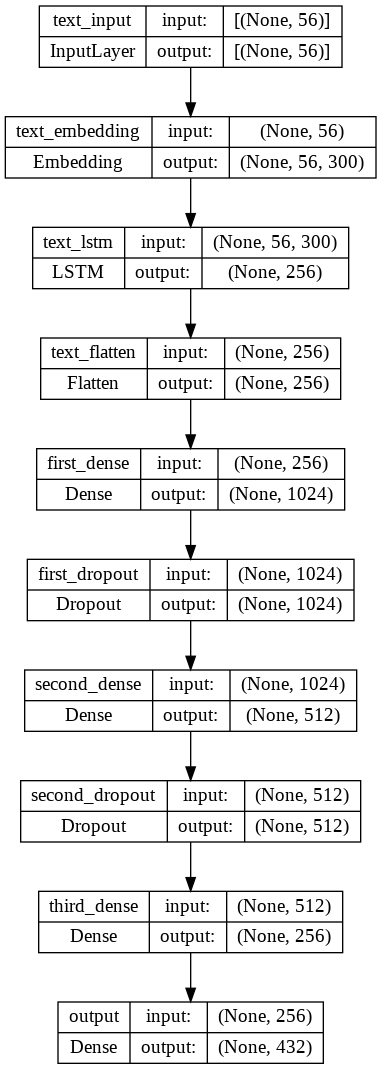

In [65]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model_1, 'model_1.png', show_shapes=True)

In [32]:
if 'model_1' not in os.listdir():
    os.mkdir('model_1')
    os.mkdir('model_1/saved_models')
    os.mkdir('model_1/tb_logs')

In [60]:
# Importing Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import datetime

In [ ]:
# Rocauc custom callback
class AucScore(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data):
        self.x = train_data[0]
        self.y = train_data[1]
        self.x_val = val_data[0]
        self.y_val = val_data[1]
        super().__init__()

    def on_train_begin(self, logs={}):
        logs = {'auc':[], 'val_auc':[]}


    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        train_auc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        val_auc = roc_auc_score(self.y_val, y_pred_val)
        logs['auc'] = train_auc
        logs['val_auc'] = val_auc 

auc_callback = AucScore(train_data=([padded_essay_train, encoded_state_train, encoded_prefix_train, encoded_grade_train, 
                           encoded_categ_train, encoded_subcateg_train, num_train], y_train), 
               val_data=([padded_essay_test, encoded_state_test, encoded_prefix_test, encoded_grade_test, 
                           encoded_categ_test, encoded_subcateg_test, num_test], y_test))       

In [66]:
# Setting callbacks
save_path = '/content/model_1/saved_models/'+'Weights-epoch{epoch:02d}-{val_loss:.4f}.hdf5'
log_path = '/content/model_1/tb_logs/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
saver = ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
stopper = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')
tensorboard = TensorBoard(log_path, histogram_freq=1)
reducer = ReduceLROnPlateau(patience=3, verbose=1)

In [67]:
# Compliling model_1
model_1.compile(optimizer= tf.keras.optimizers.SGD(0.0001),
                loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [saver, tensorboard, reducer]

# Training model_1
history_1 = model_1.fit(x=clean_input_sequences, y = train_cluster_labels, 
                        validation_data=(clean_input_seq_val, val_cluster_labels),
                        shuffle=False,
                        epochs=50,
                        batch_size=8,
                        callbacks=callbacks,
                        validation_batch_size=32)


Epoch 1/50
4267/4269 [============================>.] - ETA: 0s - loss: 5.1061 - accuracy: 0.9212
Epoch 1: val_loss improved from inf to 4.66358, saving model to /content/model_1/saved_models/Weights-epoch01-4.6636.hdf5
4269/4269 [==============================] - 28s 6ms/step - loss: 5.1059 - accuracy: 0.9212 - val_loss: 4.6636 - val_accuracy: 0.9810 - lr: 1.0000e-04
Epoch 2/50
4267/4269 [============================>.] - ETA: 0s - loss: 3.9542 - accuracy: 0.9671
Epoch 2: val_loss improved from 4.66358 to 1.43996, saving model to /content/model_1/saved_models/Weights-epoch02-1.4400.hdf5
4269/4269 [==============================] - 27s 6ms/step - loss: 3.9532 - accuracy: 0.9671 - val_loss: 1.4400 - val_accuracy: 0.9810 - lr: 1.0000e-04
Epoch 3/50
4267/4269 [============================>.] - ETA: 0s - loss: 0.4964 - accuracy: 0.9671
Epoch 3: val_loss improved from 1.43996 to 0.26559, saving model to /content/model_1/saved_models/Weights-epoch03-0.2656.hdf5
4269/4269 [===================

In [68]:
# Load best model
model = tf.keras.models.load_model('/content/model_1/saved_models/Weights-epoch03-0.2656.hdf5')

In [79]:
def predict_responses(email_text:str, no_of_responses=2):
    
    """ 
    Given the email text, suggests no_of_responses relevant responses
    
    """
    print(f"Email text: {email_text}")
    # tokenize and pad email sequences
    email_sequence = input_tokenizer.texts_to_sequences(email_text)
    email_sequence = pad_sequences(email_sequence, maxlen=IP_SENT_MAXLENGTH, padding='post')

    predicted_cluster = model.predict(email_sequence)
    predicted_cluster = np.argmax(predicted_cluster) - 1

    # mask cluster responses
    labels = dbscan.labels_
    predicted_member_mask = (labels == predicted_cluster)
    # possible responses
    response_list = (np.array(train_response_texts)[class_member_mask])

    for k in range(no_of_responses):
        idx = np.random.randint(0, len(response_list)-1, 1)
        print(f"Response {k+1}: {response_list[idx][0]}")

In [88]:
predict_responses("can you pick me up ?", 2)

Email text: can you pick me up ?
1/1 [==============================] - 0s 18ms/step
Response 1: yea i know how you feel
Response 2: yes i ate it quick


In [91]:
predict_responses("i bought a car", 2)

Email text: i bought a car
1/1 [==============================] - 0s 18ms/step
Response 1: that is awesome
Response 2: perhaps it is deer ? that is what it is been in my experience


In [102]:
predict_responses("i am sick", 2)

Email text: i am sick
1/1 [==============================] - 0s 18ms/step
Response 1: not usually
Response 2: oh


In [107]:
predict_responses("i got promotion", 2)

Email text: i got promotion
1/1 [==============================] - 0s 18ms/step
Response 1: those are always good memories
Response 2: oh wow


In [134]:
predict_responses("i went to hospital yesterday", 2)

Email text: i went to hospital yesterday
1/1 [==============================] - 0s 16ms/step
Response 1: i hate that
Response 2: how how is it where you are ?


In [164]:
predict_responses("thank you", 2)

Email text: thank you
1/1 [==============================] - 0s 16ms/step
Response 1: i hope it turns out well for you
Response 2: thanks i will


In [168]:
predict_responses("do you like to dance ?", 2)

Email text: do you like to dance?
1/1 [==============================] - 0s 16ms/step
Response 1: yes
Response 2: i believe you will get it
